In [1]:
import os
import cv2
from matplotlib import pyplot as plt 
import numpy as np
import sklearn
import random
import datetime
import time
FIRST = 0
SECOND = 15
THIRD = 22
# WLH = 4
# THREDHOLDWLH = 500
THREDHOLDFIRST = 300
THREDHOLDSECOND = 200
THREDHOLDTHIRD = 200


In [2]:
img_list = []
def read_directory(directory_name):
    for filename in os.listdir(r"./"+directory_name):
        img = cv2.imread(directory_name + "/" + filename)
#         img = cv2.resize(img, (int(img.shape[1] / 2), int(img.shape[0] / 2)))
        img_list.append(img)
read_directory("office2")
print(len(img_list))

29


In [3]:
def Matches(image1,image2):
    image1 = cv2.cvtColor(image1,cv2.COLOR_BGR2RGB)
    image2 = cv2.cvtColor(image2,cv2.COLOR_BGR2RGB)
    
    my_SIFT_instance = cv2.SIFT_create()

    imgOut1 = np.copy(image1)
    imgOut2 = np.copy(image2)
    keypoints_1, descriptors_1 = my_SIFT_instance.detectAndCompute(imgOut1,None)
    keypoints_2, descriptors_2 = my_SIFT_instance.detectAndCompute(imgOut2,None)

    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    feature = cv2.FlannBasedMatcher(index_params,search_params)
    matches = feature.knnMatch(descriptors_1,descriptors_2, k=2) 
    
    good = []
    p1 = []
    p2 = []
    minn = 0
    for m,n in matches:
        md = m.distance
        nd = n.distance 
        ratio = md / nd
        tau = 0.7
        if ratio < tau:
            good.append([m])
            p1.append(keypoints_1[m.queryIdx].pt)
            p2.append(keypoints_2[m.trainIdx].pt)
    Num = len(good)
    return keypoints_1, descriptors_1, keypoints_2, descriptors_2, good,p1, p2,Num

In [4]:
def Homography(ref,tar):
    keypoints_1, descriptors_1, keypoints_2, descriptors_2, good,p1, p2,Num = Matches(ref,tar)
    ref_pts = np.float32([keypoints_1[m[0].queryIdx].pt for m in good]).reshape(-1,1,2)
    tar_pts = np.float32([keypoints_2[m[0].trainIdx].pt for m in good]).reshape(-1,1,2)    
    f, _ = cv2.findHomography(ref_pts,tar_pts, method = cv2.RANSAC)       
    return Num,f,good

def find_postion(ref,tar,i,thrd):
    Num,f,good = Homography(ref,tar)
    
    length, width = ref.shape[:2] 
    points = np.float32([[0, 0], [0, length], [width, length], [width, 0]]).reshape(-1, 1, 2)
    dirTestPt = cv2.perspectiveTransform(points, f)
    
#     print("check")
    if Num > thrd:
        if dirTestPt[0][0][0] > 0:         
            print(str(i) +" is at the Left side, the match num is :" + str(Num))
            leftList.append([Num,tar,f,good,i])
        else:
            print(str(i) +" is at the Right side, the match num is : " + str(Num))        
            rightList.append([Num,tar,f,good,i])
    
    return leftList, rightList

In [5]:
# print("left is " + str(len(leftList)))
# print("right is " + str(len(rightList)))

In [6]:

def Stiching(ref, tar):

    
    Num,f,good =  Homography(ref,tar)
    f= np.linalg.inv(f)
    
    dsize = [ref.shape[1] + ref.shape[1], ref.shape[0]+tar.shape[0]]
    warpImg = cv2.warpPerspective(tar, f, dsize)
    warpImg[0:ref.shape[0], 0:ref.shape[1]] = ref    
#     warpImg = ChopBlackSide(warpImg)
    img = cv2.medianBlur(warpImg, 5)
    gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    _, t = cv2.threshold(gray_img, 1, 255, cv2.THRESH_BINARY)
    contour, _ = cv2.findContours(t, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contour[0]
    x,y,w,h = cv2.boundingRect(cnt)
    cropImg = img[y:y+h, x:x+w]
    warpImg = cropImg
#     plt.figure()
#     plt.imshow(warpImg)
#     plt.show()
    return warpImg


def radiometric(l_r,output,j): 
    lrimg = l_r
#     plt.imshow(lrimg)
    srcImg = cv2.copyMakeBorder(lrimg,100, 100, 0, 500, cv2.BORDER_CONSTANT,value=(0,0,0))
    testImg = cv2.copyMakeBorder(output,100, 100, 0, 500,cv2.BORDER_CONSTANT,value=(0,0,0))
    lenghs, height = srcImg.shape[:2]
    kp1,dp1,kp2,dp2,good,p1, p2, Num =  Matches(srcImg,testImg)
#     good = leftA[j][3]
    if len(good) > 4:
        src_pts = np.float32([kp1[m[0].queryIdx].pt for m in good]).reshape(-1,1,2)
        dst_pts = np.float32([kp2[m[0].trainIdx].pt for m in good]).reshape(-1,1,2)
        f,mask = cv2.findHomography(src_pts,dst_pts, cv2.RANSAC, 5)
#         f = leftA[j][2]
        warpImg = cv2.warpPerspective(testImg, np.array(f), (testImg.shape[1],testImg.shape[0]),flags=cv2.WARP_INVERSE_MAP)
        for column in range(0,height):
            if srcImg[:, column].any() and warpImg[:,column].any():
                left = column
                break
        for column in range(height-1,0,-1):
            if srcImg[:, column].any() and warpImg[:,column].any():
                right = column
                break
        background = np.zeros([lenghs, height, 3], np.uint8)
        for row in range(0, lenghs):
            for column in range(0, height):
                if not srcImg[row, column].any():
                    background[row,column] = warpImg[row, column]
                elif not warpImg[row, column].any():
                    background[row, column] = srcImg[row, column]
                else:
                    srcImgLen = float(abs(column - left))
                    testImgLen = float(abs(column-right))
                    alpha = srcImgLen / (srcImgLen + testImgLen)
                    background[row, column] = np.clip(srcImg[row, column] * (1-alpha)+ warpImg[row,column] * alpha, 0, 255)
        final = background
        return final


In [7]:
#geo metric 
def geo_metric(img_list, num, thrd):
    for i in range(0,len(img_list)):
        if i == num:
            continue
        else:
            leftList, rightList = find_postion(img_list[num],img_list[i],i,thrd)
    #         leftList, rightList,keypoints_1, descriptors_1, keypoints_2, descriptors_2, good, p1, p2, Num, f = Homography(img_list[MEAN],img_list[i],i)
    init = leftList[-1][1]
    for i in range(2,len(leftList)+1):
        init = Stiching(leftList[-i][1], init)
    print("left done")
    init = Stiching(img_list[num], init)
    templ = init

    init = rightList[-1][1]
    for i in range(2,len(rightList)+1):
        init = Stiching(rightList[-i][1], init)
    print("right done")
    init = Stiching(img_list[num], init)
    tempr = init

    init = Stiching(templ, tempr)
    init = cv2.cvtColor(init,cv2.COLOR_BGR2RGB)

    # final = ChopshapeBlack(init, img_list[num].shape[0])
    plt.imshow(init) 
    plt.show()


In [8]:
#radio metric 
def radio_metric(img_list, num, thrd):
    for i in range(0,len(img_list)):
        if i == num:
            continue
        else:
            leftList, rightList = find_postion(img_list[num],img_list[i],i,thrd)
    #         leftList, rightList,keypoints_1, descriptors_1, keypoints_2, descriptors_2, good, p1, p2, Num, f = Homography(img_list[MEAN],img_list[i],i)
    init = leftList[-1][1]
    for i in range(2,len(leftList)+1):
        init = radiometric(leftList[-i][1], init,i)
    print("left done")
    init = radiometric(img_list[num], init,i)
    templ = init

    init = rightList[-1][1]
    for i in range(2,len(rightList)+1):
        init = radiometric(rightList[-i][1], init,i)
    print("right done")
    init = radiometric(img_list[num], init,i)
    tempr = init

    init = radiometric(templ, tempr,1)
    init = cv2.cvtColor(init,cv2.COLOR_BGR2RGB)

    # final = ChopshapeBlack(init, img_list[num].shape[0])
    plt.imshow(init) 
    plt.show()

1 is at the Right side, the match num is : 728
2 is at the Right side, the match num is : 430
26 is at the Left side, the match num is :362
27 is at the Left side, the match num is :436
28 is at the Left side, the match num is :542
left done
right done


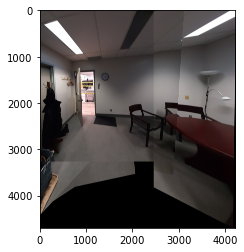

Running time is 65.28445243835449


In [9]:
start = time.time()
leftList = []
rightList = []
geo_metric(img_list,FIRST,THREDHOLDFIRST)

end = time.time()
leftList.clear() 
rightList.clear()
print("Running time is " + str(end-start))

11 is at the Left side, the match num is :206
12 is at the Left side, the match num is :245
13 is at the Left side, the match num is :391
14 is at the Left side, the match num is :727
16 is at the Right side, the match num is : 835
17 is at the Right side, the match num is : 435
18 is at the Right side, the match num is : 217
left done
right done


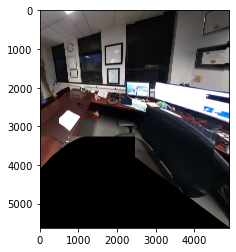

Running time is 76.66444826126099


In [10]:
start = time.time()
leftList = []
rightList = []
geo_metric(img_list,SECOND,THREDHOLDSECOND)
end = time.time()
leftList.clear() 
rightList.clear()
print("Running time is " + str(end-start))

20 is at the Left side, the match num is :239
21 is at the Left side, the match num is :453
23 is at the Right side, the match num is : 573
24 is at the Right side, the match num is : 221
left done
right done


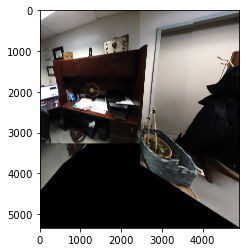

Running time is 68.20146369934082


In [11]:
start = time.time()
leftList = []
rightList = []
geo_metric(img_list,THIRD,THREDHOLDTHIRD)
end = time.time()
leftList.clear() 
rightList.clear()
print("Running time is " + str(end-start))

1 is at the Right side, the match num is : 728
2 is at the Right side, the match num is : 430
26 is at the Left side, the match num is :362
27 is at the Left side, the match num is :436
28 is at the Left side, the match num is :542
left done
right done


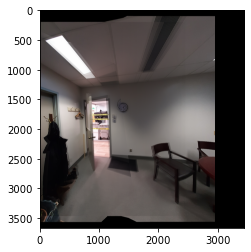

Running time is 658.4054925441742


In [12]:
start = time.time()
leftList = []
rightList = []
radio_metric(img_list,FIRST,THREDHOLDFIRST)
end = time.time()
leftList.clear() 
rightList.clear()
print("Running time is " + str(end-start))

11 is at the Left side, the match num is :206
12 is at the Left side, the match num is :245
13 is at the Left side, the match num is :391
14 is at the Left side, the match num is :727
16 is at the Right side, the match num is : 835
17 is at the Right side, the match num is : 435
18 is at the Right side, the match num is : 217
left done
right done


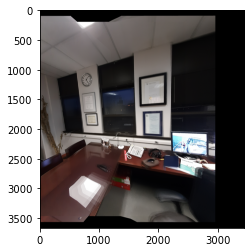

Running time is 858.5626208782196


In [13]:
start = time.time()
leftList = []
rightList = []
radio_metric(img_list,SECOND,THREDHOLDSECOND)
end = time.time()
leftList.clear() 
rightList.clear()
print("Running time is " + str(end-start))

In [14]:
WLH = 2
THREDHOLDWLH = 400

In [15]:
img_list = []
def read_directory(directory_name):
    for filename in os.listdir(r"./"+directory_name):
        img = cv2.imread(directory_name + "/" + filename)
        img = cv2.resize(img, (int(img.shape[1] / 2), int(img.shape[0] / 2)))
        img_list.append(img)
read_directory("WLH")
print(len(img_list))

25


0 is at the Right side, the match num is : 733
1 is at the Right side, the match num is : 1298
3 is at the Left side, the match num is :1225
4 is at the Left side, the match num is :814
13 is at the Right side, the match num is : 859
14 is at the Right side, the match num is : 725
15 is at the Right side, the match num is : 642
16 is at the Left side, the match num is :414
20 is at the Right side, the match num is : 571
21 is at the Right side, the match num is : 523
22 is at the Right side, the match num is : 507
left done
right done


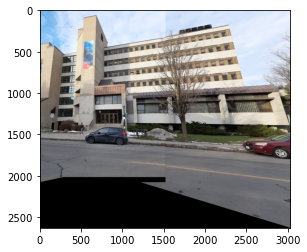

Running time is 217.6526803970337


In [16]:
start = time.time()
leftList = []
rightList = []
geo_metric(img_list,WLH,THREDHOLDWLH)
end = time.time()
leftList.clear() 
rightList.clear()
print("Running time is " + str(end-start))